Investigation the staticstial realtionship between the price and two-side factors, which may contribute on price.

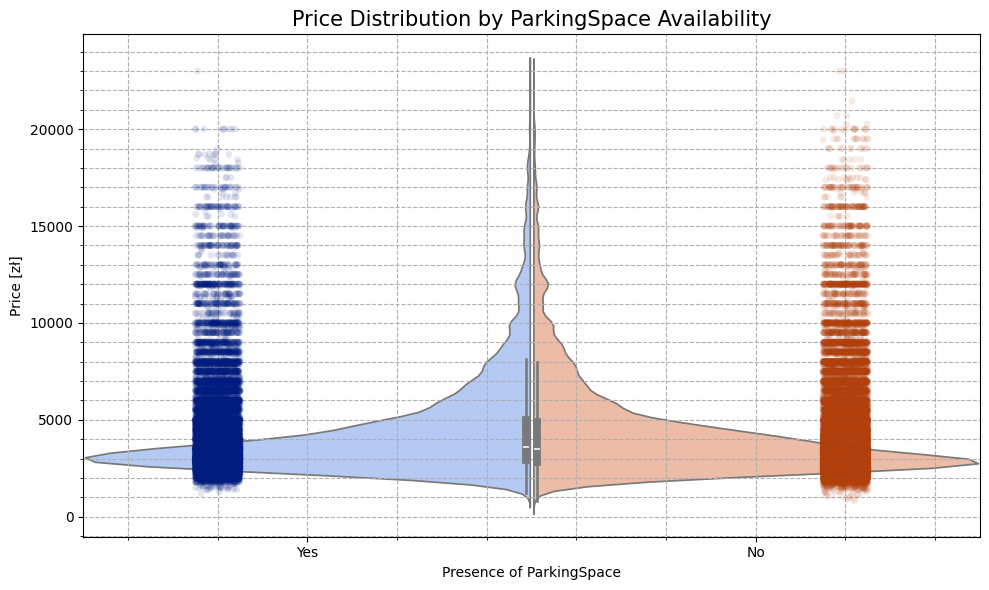

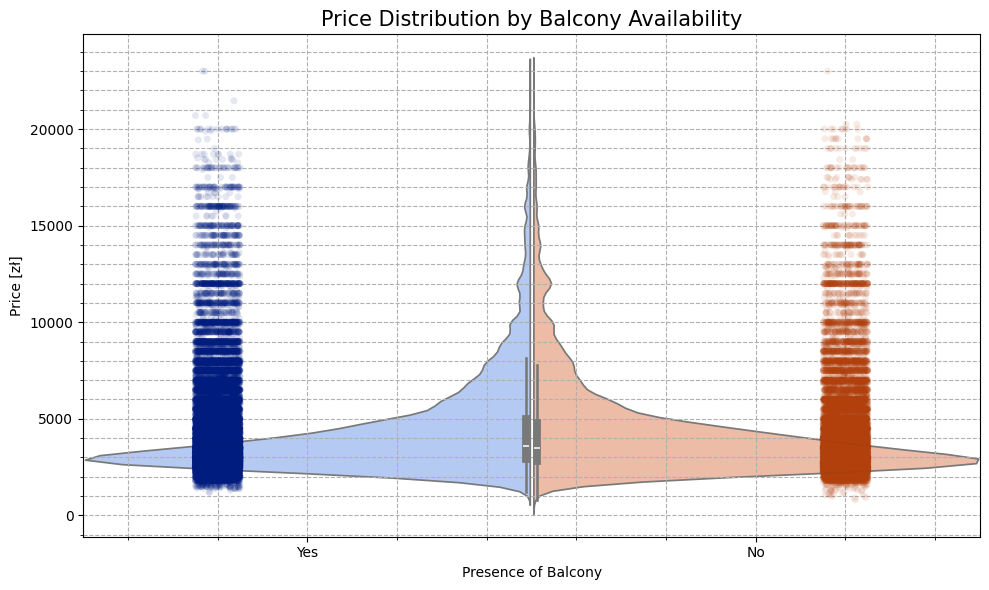

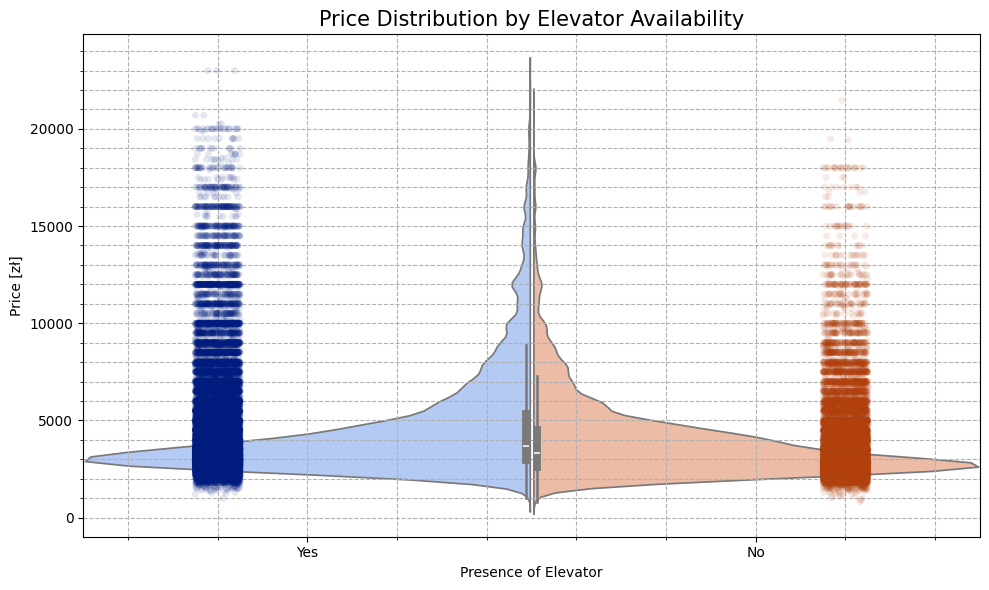

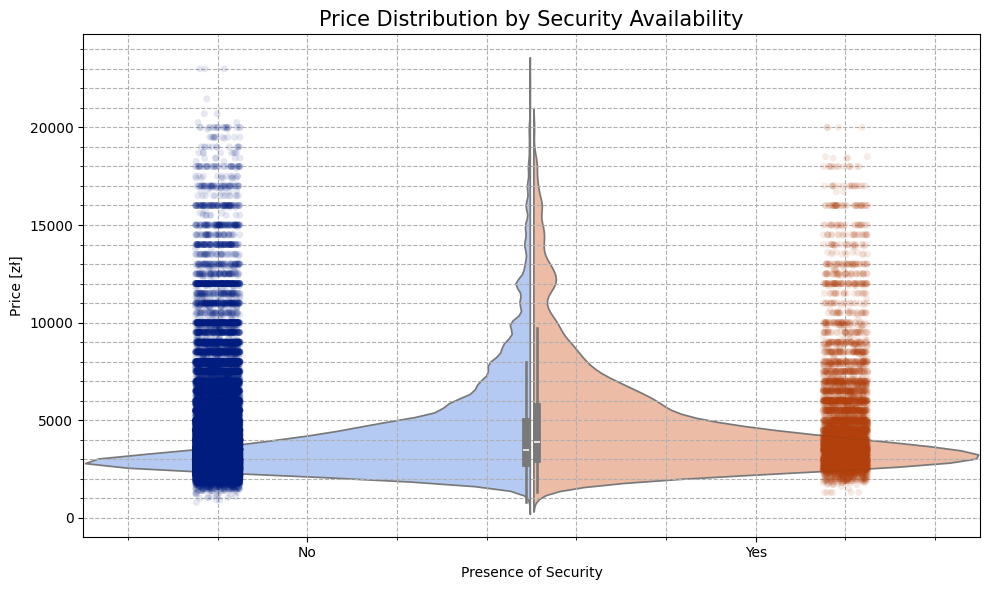

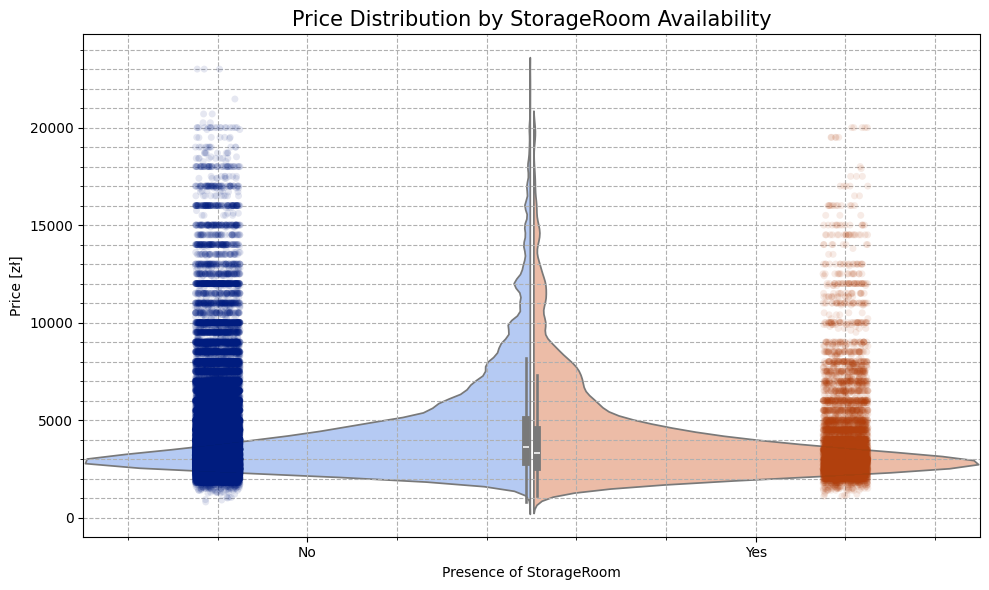

=================Stats for 1_analysis__rent.csv=====================
           feature   p-value(MWU)         stat  p-value(t-test)     t_stat  \
0  hasParkingSpace   1.282839e-22  299195275.5     2.786866e-10   6.311708   
1       hasBalcony   1.038887e-21  287821485.5     1.607497e-08   5.650917   
2      hasElevator  6.571433e-222  309862522.0    2.214775e-204  30.678052   
3      hasSecurity   3.860378e-72  161206425.0     8.484758e-46  14.289129   
4   hasStorageRoom   8.005846e-62  115296198.0     8.806222e-25 -10.311165   

    p-value(KST)  D-statistic  Cliff's Delta Size Cliff's  
0   3.075420e-25     0.049308       0.052138   negligible  
1   3.470332e-20     0.044859       0.051994   negligible  
2  1.441997e-165     0.131952       0.175994        small  
3   4.137077e-49     0.097669       0.135426   negligible  
4   3.520771e-53     0.105243      -0.129515   negligible  
---------------------
           feature  p-value(MWU)  p-value(t-test)  t_stat  p-value(KST)  \
0  ha

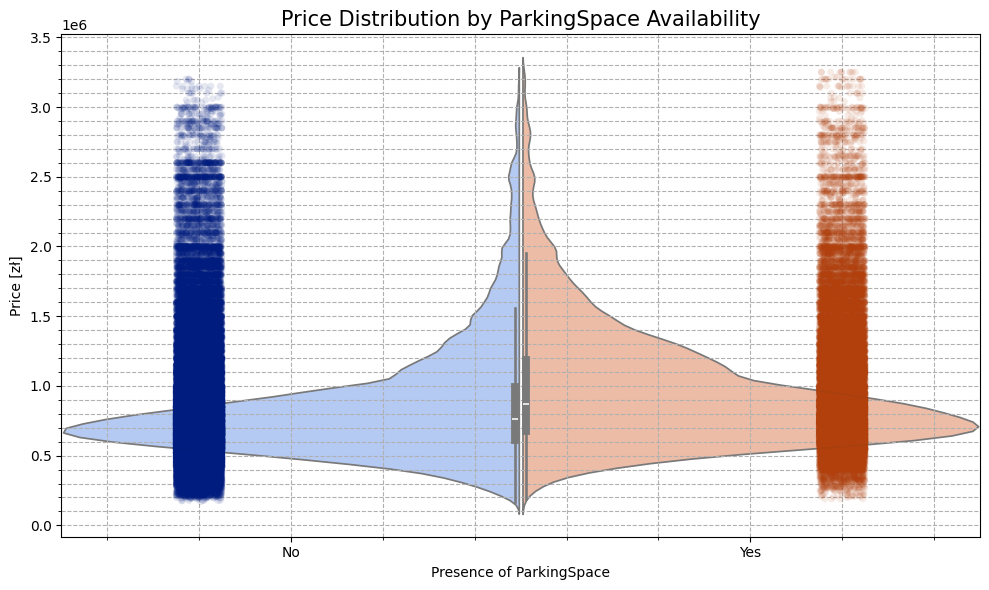

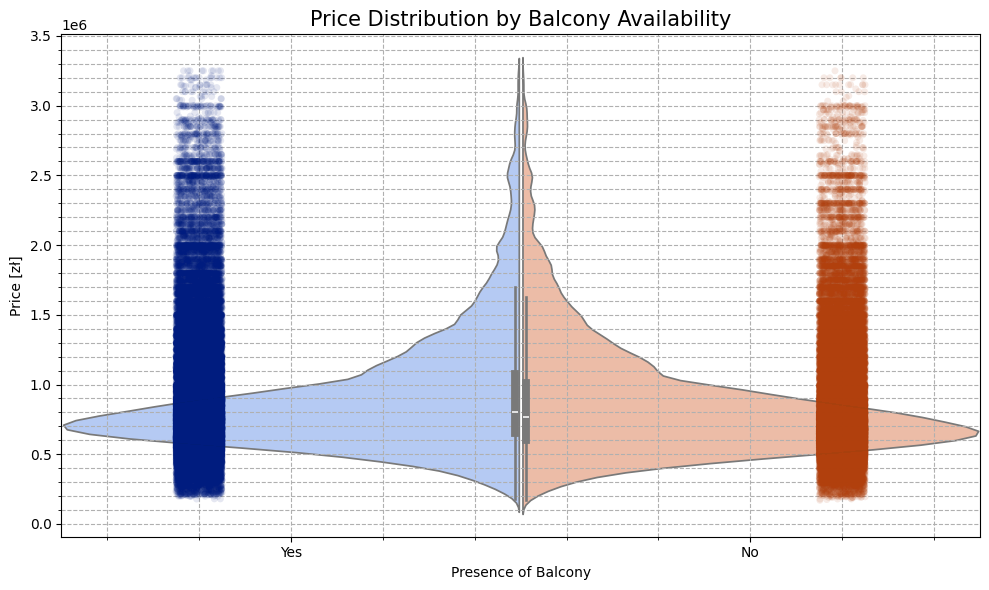

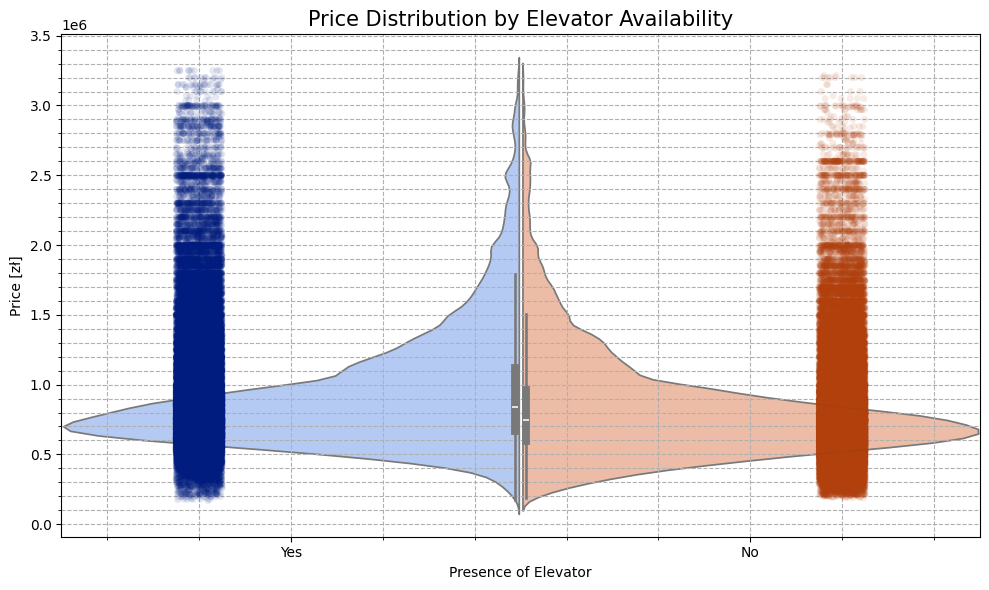

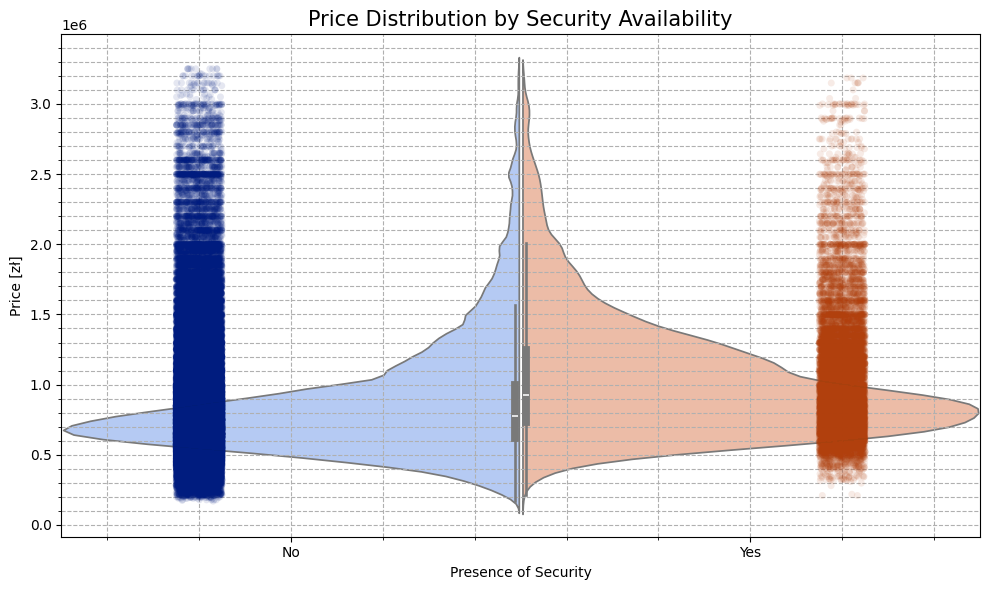

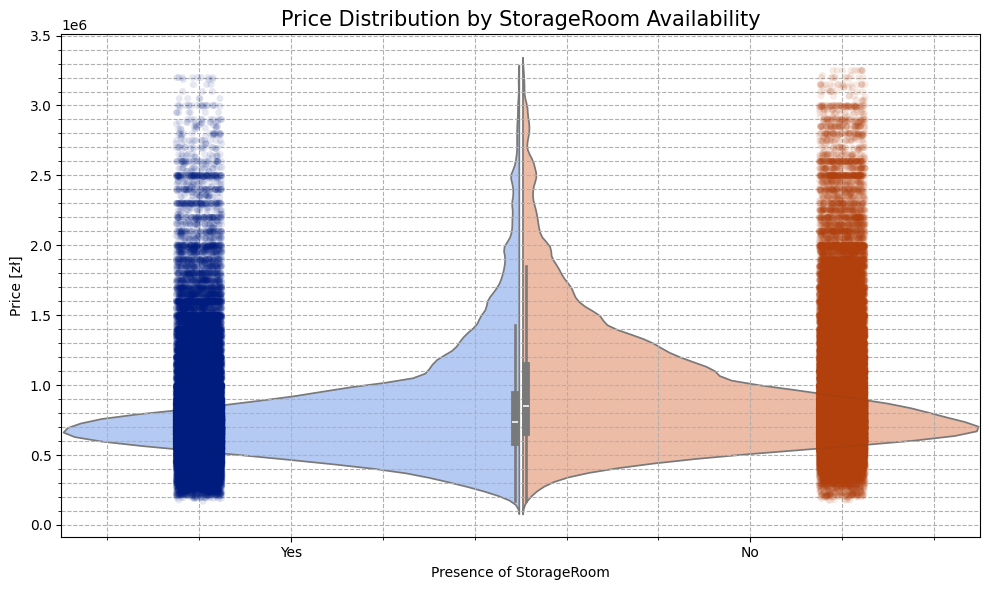

=================Stats for 2_analysis__purchase.csv=====================
           feature   p-value(MWU)          stat  p-value(t-test)     t_stat  \
0  hasParkingSpace   0.000000e+00  1.733016e+09     0.000000e+00  43.466040   
1       hasBalcony  4.830108e-113  1.749463e+09     1.282753e-54  15.572977   
2      hasElevator   0.000000e+00  1.979954e+09     0.000000e+00  48.127520   
3      hasSecurity   0.000000e+00  9.097729e+08     0.000000e+00  40.936869   
4   hasStorageRoom   0.000000e+00  1.281538e+09     0.000000e+00 -56.241691   

    p-value(KST)  D-statistic  Cliff's Delta Size Cliff's  
0   0.000000e+00     0.146352       0.189857        small  
1  9.492430e-129     0.072537       0.077904   negligible  
2   0.000000e+00     0.140648       0.190800        small  
3   0.000000e+00     0.208761       0.264960        small  
4   0.000000e+00     0.165332      -0.214605        small  
---------------------
           feature  p-value(MWU)  p-value(t-test)  t_stat  p-value(KST

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
import cliffs_delta

path="./../data/processed/"
files=os.listdir(path)
for file in files:
    data=pd.read_csv(path+file)

    column_list=data.columns

    stats_contrast=[]
    stats_contrast_group=[] #easier to compare from table[0-1] values
    two_side_columns=[]

    #Exstraction of two-side columns
    for col in column_list:
        num_unique = data[col].nunique()
        if num_unique ==2:
            two_side_columns.append(col)

    #Computing Statistical Values 
    for col in two_side_columns:
        feature=data[data[col]==True]['price']
        no_feature=data[data[col]==False]["price"]

        #Mann-Whteney U
        stat,p_MWU=mannwhitneyu(feature,no_feature,alternative="two-sided")

        if p_MWU < 0.05:
            e1=1
        elif p_MWU>=0.05:
            e1=0
        
        #T-test
        t_stat,p_ttest=ttest_ind(feature,no_feature,equal_var=False)

        if abs(t_stat) < 1:
            e21=0
        elif abs(t_stat) < 1.96:
            e21=0.95
        elif abs(t_stat) < 2.58:
            e21=0.99
        else:
            e21=1
        
        if p_ttest < 0.05:
            e22=1
        elif p_ttest>=0.05:
            e22=0
        
        #Kolmogorov-Smirnov Test
        ks_stat,p_ks=ks_2samp(feature,no_feature)
        ks_stat=ks_stat
    
        if p_ks <0.05:
            e3=1
        else:
            e3=0
        
        #Cliff's Delta
        delta,res=cliffs_delta.cliffs_delta(feature.to_list(),no_feature.to_list())

        if abs(delta)<0.147:
            e4=0
        elif 0.147<=abs(delta)<0.33:
            e4=0.50
        elif 0.33<=abs(delta) <0.474:
            e4=0.75
        elif abs(delta) >= 0.0474:
            e4=1
        

        new_record={"feature":col,
        "p-value(MWU)":p_MWU,"stat":stat,
        "p-value(t-test)":p_ttest,"t_stat":t_stat,
        "p-value(KST)":p_ks,"D-statistic":ks_stat,
        "Cliff's Delta":delta,"Size Cliff's":res}

        new_record_group={"feature":col,"p-value(MWU)":e1,
        "p-value(t-test)":e22,"t_stat":e21,
        "p-value(KST)":e3,"D-statistic":ks_stat,
        "Cliff's Delta":e4
        }

        stats_contrast.append(new_record)
        stats_contrast_group.append(new_record_group)

        data1=pd.DataFrame(stats_contrast)
        data2=pd.DataFrame(stats_contrast_group)

        data2["Sum_of_rows"] = data2.select_dtypes(include=[np.number]).sum(axis=1)

        #Some graphs
        data[col] = data[col].map({False: 'No', True: 'Yes'})
        plt.figure(figsize=(10,6))
        sns.violinplot(data=data,x=col,y="price",hue=col, inner="box",palette="coolwarm",split=True,gap=-0.24)
        sns.stripplot(data=data, x=col, y="price",hue=col, palette="dark",alpha=0.1,jitter=True,dodge=True)

        plt.title("Price Distribution by "+col[3:]+" Availability", fontsize=15)
        plt.xlabel("Presence of "+col[3:])
        plt.ylabel("Price [zł]")

        plt.grid(True,which="both",linestyle="--")
        plt.minorticks_on()
        plt.tight_layout()

        plt.savefig("./../plots/stats_two_side/"+file[0]+"_"+col[3:]+"_distribution")
        plt.show()








    
    data1.to_csv("./../reports/"+file[0]+"_stats_"+file[2:],index=False)
    data2.to_csv("./../reports/"+file[0]+"_stats_easy_"+file[2:],index=False)
    


    print("=================Stats for "+file+"=====================")
    print(data1)
    print("---------------------")
    print(data2)


Selecting feature with the leargest difference to price

In [2]:
import pandas as pd
path='./../reports/'

data1=pd.read_csv(path+"1_stats_easy_analysis__rent.csv",index_col=0)
data2=pd.read_csv(path+"2_stats_easy_analysis__purchase.csv",index_col=0)

data1=data1.sort_values("Sum_of_rows", ascending=False)
data2=data2.sort_values("Sum_of_rows", ascending=False)


print("Rent \n",data1[[data1.columns[-1]]])

print("Purchase \n",data2[[data2.columns[-1]]])

Rent 
                  Sum_of_rows
feature                     
hasElevator         4.631952
hasStorageRoom      4.105243
hasSecurity         4.097669
hasParkingSpace     4.049308
hasBalcony          4.044859
Purchase 
                  Sum_of_rows
feature                     
hasSecurity         4.708761
hasStorageRoom      4.665332
hasParkingSpace     4.646352
hasElevator         4.640648
hasBalcony          4.072537


We can obsere stron corelation with price and presence of elevator, storageroom and security for rent, and presence of security, storage room and parking space for purchase. Although for all features, strong colleration with price is observed.